### Overview

Here, we evaluate how well our communities agree with Hallmark pathways. We do the following steps:
1. load all pathways in our pathway graph along with the learned community assignments.
2. load Hallmark pathways and identify which of our pathways are founders of any Hallmark pathways.
3. Create a heatmap highlighting the distribution of Hallmark founders within our communities
4. Generate bar graphs showing the distribution of database sources and sizes for each community


In [1]:
import networkx as nx
import numpy as np
import os
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

from sklearn.metrics import normalized_mutual_info_score

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.font_manager
from matplotlib import rcParams


import utils

## Load gene sets

In [2]:
acronym_to_folder = {"KEGG": "c2.all.v7.0.symbols_JustK", "REACTOME":"c2.all.v7.0.symbols_JustR",
                  "GO_BP": "c5.bp.v7.0.symbols_SHORT", "GO_CC": "c5.cc.v7.0.symbols", "GO_MF": "c5.mf.v7.0.symbols"}
folder_to_acronym = utils.reverse_dict(acronym_to_folder, assume_unique = True)

pway_subfolders =  'c2.all.v7.0.symbols_JustK-c2.all.v7.0.symbols_JustR-c5.bp.v7.0.symbols_SHORT-c5.mf.v7.0.symbols'

gsets_folders = pway_subfolders.split("-")
gsets_acronyms = [folder_to_acronym[x] for x in gsets_folders]

In [4]:
pathways = {}
pway_indices = {}

cur_idx = 0
for foldername in gsets_folders:
    name = folder_to_acronym[foldername]
    pathways[name] = np.loadtxt('../adj_matrices/%s/pathway_names.txt'%foldername, dtype=str)
    pway_indices[name] = np.arange(cur_idx, cur_idx + len(pathways[name])).astype(int)
    cur_idx += len(pathways[name])
    
total_num_pathways = np.sum([len(x) for x in pathways.values()])

pathway_names = np.hstack([pathways[name] for name in gsets_acronyms])

### Load community assignments

In [ ]:
new_com_df = pd.read_csv("../Full_graph_louvain_with_weights_community_labels/0.4/labels.tsv", delimiter="\t", names=["pathways", "com"])
new_com_df = new_com_df.merge(pd.DataFrame(pathway_names.reshape(len(pathway_names),1), columns=["pathways"]), how="right", on="pathways")
coms = new_com_df["com"].values

# Load/process hallmark labels
(Note: some hallmark pathways have identical sets of founders, although the gene lists are different. For the sake of the figure, when this happen, we include both hallmark pathways in the same row) 

In [5]:
hallmark_gmt = pd.read_csv("../../pathways_raw/h.all.v7.1.symbols.gmt", header=None)
hallmark_gmt["names"] = hallmark_gmt[0].apply(lambda x: x.split("\t")[0])
hallmark_gmt["urls"] = hallmark_gmt[0].apply(lambda x: x.split("\t")[1])
hallmark_gmt["genes"] = hallmark_gmt[0].apply(lambda x: x.split("\t")[2:])

hallmark_founders = {}
for pway in hallmark_gmt["names"].values:
    
    pway_clean_name = pway[9:].replace("_", " ")

    url = "http://software.broadinstitute.org/gsea/msigdb/cards/%s"%pway
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    td_tags = soup.find_all("td")
    founder_gsets = td_tags[10].text.split("\n\n")[3:-5]

    hallmark_founders[pway_clean_name] = np.array(founder_gsets)

In [6]:
tmp = np.array([[len(np.intersect1d(hallmark_founders[k1],hallmark_founders[k2])) for k2 in hallmark_founders.keys()] for k1 in hallmark_founders.keys()])
founders_overlaps = pd.DataFrame(tmp, index= hallmark_founders.keys(), columns= hallmark_founders.keys())
pway_to_hallmark = utils.reverse_dict_lists(hallmark_founders)

hallmark_labels_multiple = []
for pathway_group in ["KEGG", "REACTOME", "GO_BP", "GO_MF"]:
    for pway in pathways[pathway_group]:
        if pway in pway_to_hallmark.keys():
            hallmark_labels_multiple.append(pway_to_hallmark[pway])
        else:
            hallmark_labels_multiple.append([])

In [7]:
hallmark_labels_multiple_combined = {}
pways_w_hallmark_idx = []
for i,elt in enumerate(hallmark_labels_multiple):
    if len(elt)>1:
        hallmark_labels_multiple_combined[pathway_names[i]] = "-&-".join(elt)
        pways_w_hallmark_idx.append(i)
    elif len(elt)==1:
        hallmark_labels_multiple_combined[pathway_names[i]] = elt[0]
        pways_w_hallmark_idx.append(i)

In [8]:
pways_w_hallmark = pathway_names[pways_w_hallmark_idx]
pathway_hm_founders_df = pd.DataFrame.from_dict({"pathways": list(hallmark_labels_multiple_combined.keys()), 
                        "hallmark": list(hallmark_labels_multiple_combined.values())})
# pathway_hm_founders_df.to_csv("pathways_to_hallmark_founders.csv")

## HALLMARK VS COMMUNITY HEATMAPS

In [12]:
all_hallmark = np.unique(list(hallmark_labels_multiple_combined.values()))
hallmark_count_mx = np.zeros([len(np.unique(coms)), len(all_hallmark)])
for com in np.unique(coms):
    pway_idx = np.where(coms==com)
    
    # identify pathways in the community that also have hallmark labels
    pway_idx_w_hallmark = np.intersect1d(pway_idx, pways_w_hallmark_idx)

    for pway in pway_idx_w_hallmark: 
        cur_hm_name = hallmark_labels_multiple_combined[pathway_names[pway]]
        hallmark_count_mx[com, np.where(all_hallmark == cur_hm_name)[0][0]] += 1
        
com_hallmark_counts = pd.DataFrame(hallmark_count_mx, columns=all_hallmark)
normed_com_hallmark_counts =  pd.DataFrame(np.array([x/sum(x) for x in hallmark_count_mx]), columns=all_hallmark)

/homes/gws/nbbwang/anaconda3/envs/py36-test2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [13]:
com_hallmark_counts.index = np.arange(1,len(com_hallmark_counts)+1)
normed_com_hallmark_counts.index = np.arange(1,len(normed_com_hallmark_counts)+1)

normed_hallmark_founder_counts =  pd.DataFrame(np.array([x/sum(x) for x in hallmark_count_mx.T]), columns=np.unique(coms)+1, index=all_hallmark)

In [14]:
COUNT_DF = com_hallmark_counts.T
DF_TO_PLOT = normed_com_hallmark_counts.T
min_com_size = 0
keep_coms = COUNT_DF.sum(axis=0) > min_com_size
toplot = DF_TO_PLOT[1+np.where(keep_coms)[0]]
toplot=toplot.fillna(0)

In [15]:

cmap = plt.cm.tab20b
cmaplist = [cmap(i) for i in range(cmap.N)]
newcmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', [(.97, .97, 1, 1), cmaplist[2],cmaplist[1], cmaplist[0]])

cmap_outlines = mpl.cm.get_cmap("spring")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


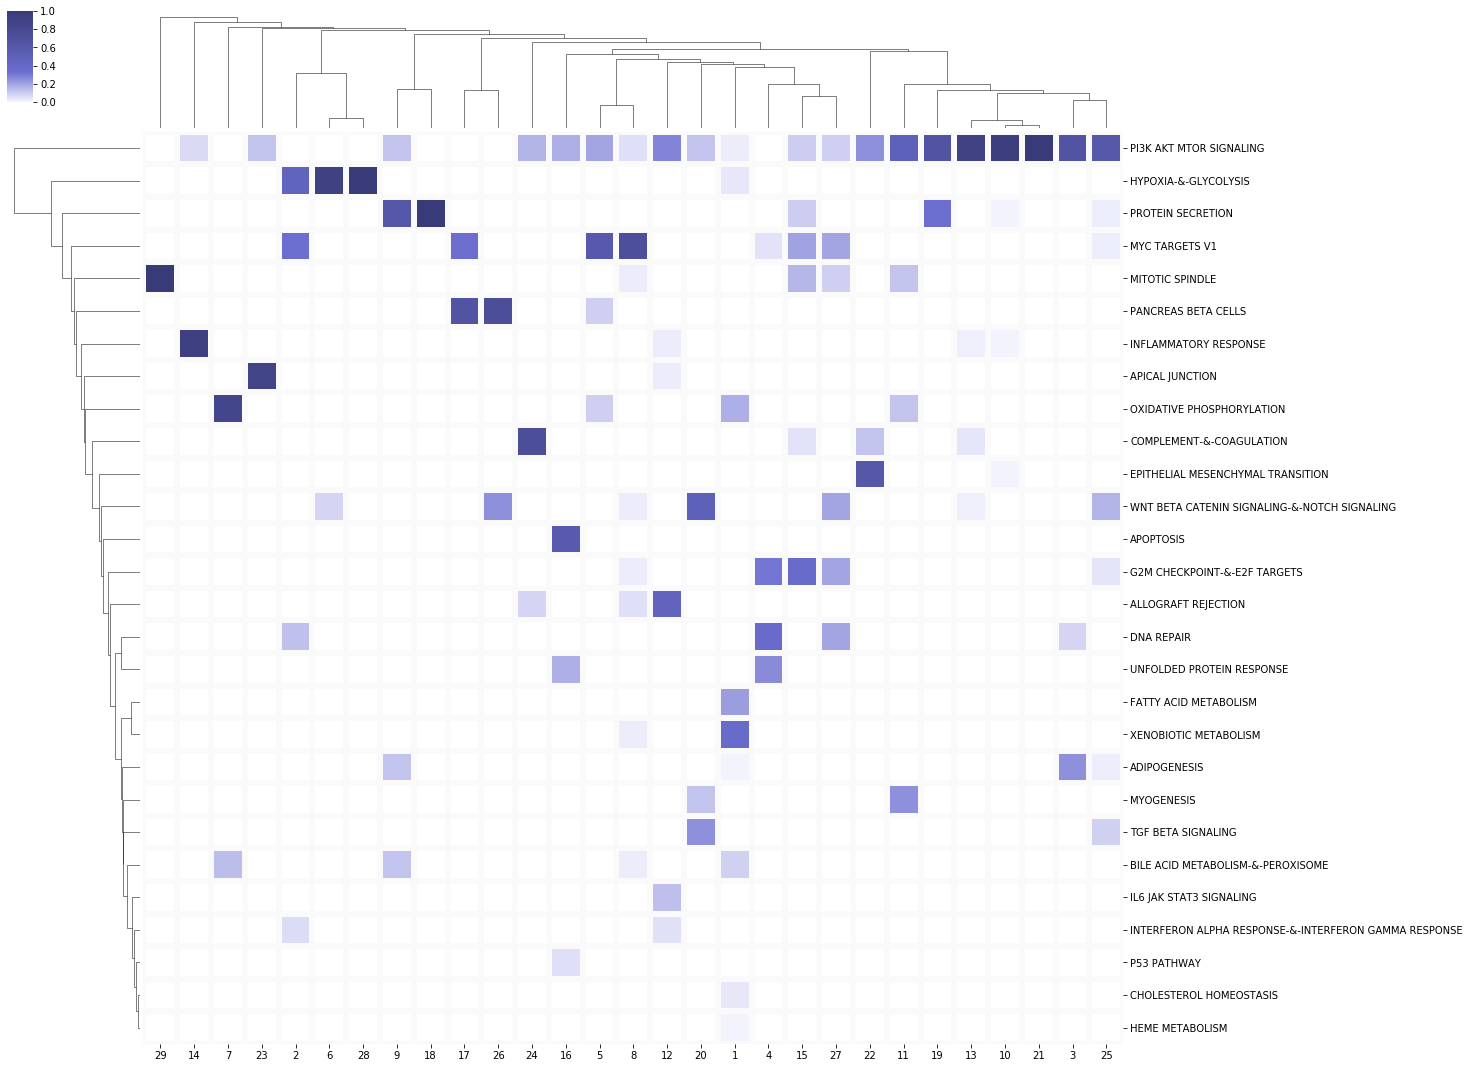

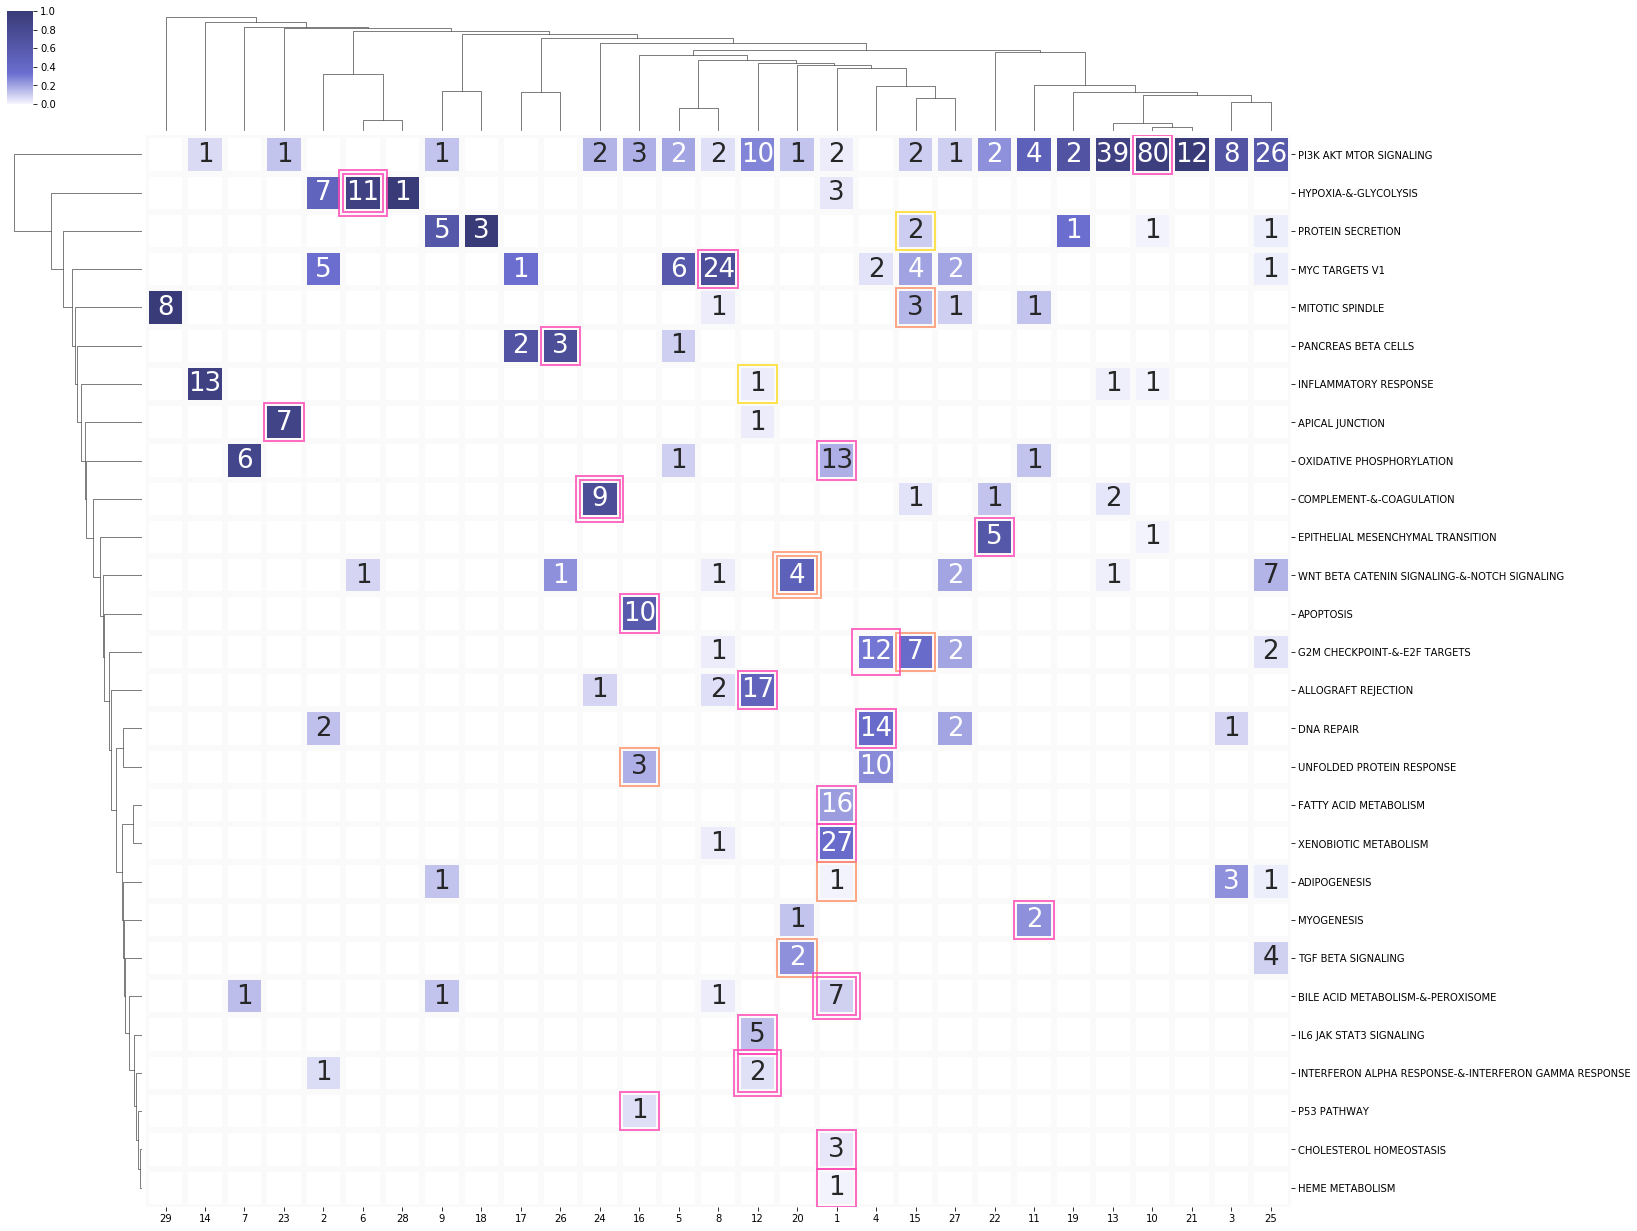

In [16]:
REORDER_ROWS = False
REORDER_COLS = False

specific_com = 3

col_cluster=False

m = (toplot == 0)


if REORDER_ROWS:
    row_cluster=False
    if specific_com==None:
        reordered_rows = list(toplot.sum(axis=1).sort_values(ascending=False).index)
    else:
        reordered_rows = list(toplot.sort_values(specific_com, ascending=False).index)
else:
    row_cluster=True
    reordered_rows = list(toplot.index)
    
if REORDER_COLS:
    col_cluster=False
    reordered_cols = (toplot>0).sum().sort_values().index
else:
    col_cluster=True
    reordered_cols = list(toplot.columns)
    
    

labels = COUNT_DF.loc[reordered_rows,reordered_cols].astype(int).astype(str)
labels[labels=="0"] = ""

g_0 = sns.clustermap(toplot.loc[reordered_rows,reordered_cols], row_cluster=row_cluster, col_cluster=col_cluster, 
                    figsize=(20, 19), cmap=newcmap, yticklabels=True, linewidths=5, 
                   xticklabels=True, linecolor=(.98,.98,.98), mask = toplot.loc[reordered_rows,reordered_cols]==0)

new_hm_idx = g_0.dendrogram_row.reordered_ind
new_hm_order = np.array(reordered_rows)[new_hm_idx]
new_com_idx = g_0.dendrogram_col.reordered_ind
new_com_order = np.array(reordered_cols)[new_com_idx]

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']


g = sns.clustermap(toplot.loc[reordered_rows,reordered_cols], row_cluster=row_cluster, col_cluster=col_cluster, 
                    figsize=(23, 22), cmap=newcmap, yticklabels=True, linewidths=5, 
                   xticklabels=True, linecolor=(.98,.98,.98), mask = toplot.loc[reordered_rows,reordered_cols]==0,
                   annot=labels.loc[new_hm_order,new_com_order], fmt="s", annot_kws={"fontsize":26, "fontfamily": "sans-serif"})

ax = g.ax_heatmap

assigned_com_ranks = []

for i,elt in enumerate(toplot.index[new_hm_idx]):
    tmp = elt.split("-&-")
    for ring_num, hm in enumerate(tmp):
#         print(hm)
        assigned_com = assigned_hm.loc["HALLMARK_" + hm.replace(" ", "_")].values[0]
#         print(assigned_com, i)
        assigned_com_loc = new_com_idx.index(assigned_com)
    
        founderrank_of_assined_com = 1+list(np.argsort(normed_hallmark_founder_counts.loc[elt])[::-1]).index(assigned_com)

        outlinecolor = cmap_outlines(founderrank_of_assined_com/3.5)
        
        if ring_num == 1:
            ax.add_patch(Rectangle((assigned_com_loc-.1, i-.1), 1.2, 1.2, fill=False, edgecolor=outlinecolor, lw=2, alpha=.8))
        else:
            ax.add_patch(Rectangle((assigned_com_loc, i), 1, 1, fill=False, edgecolor=outlinecolor, lw=2, alpha=.8))

        assigned_com_ranks.append(founderrank_of_assined_com)

In [17]:
print('rank of assigned community based on founders\' membership:')
print(pd.Series(assigned_com_ranks).value_counts())

rank of assigned community based on founders' membership:
1    25
2     7
3     2
dtype: int64


In [18]:
coms_plot_idx = np.append(g.dendrogram_col.reordered_ind, np.setdiff1d(np.unique(coms), g.dendrogram_col.reordered_ind))

In [19]:
hm_num_founders_total = com_hallmark_counts.sum(axis=0)


## Axis labels for communities:
for elt in com_hallmark_counts.columns[np.array(g.dendrogram_row.reordered_ind)]:
    print("%s (%i)"%(elt, hm_num_founders_total.loc[elt]))

PI3K AKT MTOR SIGNALING (201)
HYPOXIA-&-GLYCOLYSIS (22)
PROTEIN SECRETION (13)
MYC TARGETS V1 (45)
MITOTIC SPINDLE (14)
PANCREAS BETA CELLS (6)
INFLAMMATORY RESPONSE (16)
APICAL JUNCTION (8)
OXIDATIVE PHOSPHORYLATION (21)
COMPLEMENT-&-COAGULATION (13)
EPITHELIAL MESENCHYMAL TRANSITION (6)
WNT BETA CATENIN SIGNALING-&-NOTCH SIGNALING (17)
APOPTOSIS (10)
G2M CHECKPOINT-&-E2F TARGETS (24)
ALLOGRAFT REJECTION (20)
DNA REPAIR (19)
UNFOLDED PROTEIN RESPONSE (13)
FATTY ACID METABOLISM (16)
XENOBIOTIC METABOLISM (28)
ADIPOGENESIS (6)
MYOGENESIS (3)
TGF BETA SIGNALING (6)
BILE ACID METABOLISM-&-PEROXISOME (10)
IL6 JAK STAT3 SIGNALING (5)
INTERFERON ALPHA RESPONSE-&-INTERFERON GAMMA RESPONSE (3)
P53 PATHWAY (1)
CHOLESTEROL HOMEOSTASIS (3)
HEME METABOLISM (1)


In [20]:
# axis labels for community:
for elt in (1+np.array(g.dendrogram_col.reordered_ind, dtype=int)):
    print(elt)

29
14
7
23
2
6
28
9
18
17
26
24
16
5
8
12
20
1
4
15
27
22
11
19
13
10
21
3
25


### Generate bar charts for community size & composition aligned with clustermap

In [21]:
tab10_cmap = mpl.cm.get_cmap("tab10")
database_colors = {"KEGG":mpl.colors.to_hex(tab10_cmap(1)),
"REACTOME":mpl.colors.to_hex(tab10_cmap(8)),
"GO_BP":mpl.colors.to_hex(tab10_cmap(6)),
"GO_MF":mpl.colors.to_hex(tab10_cmap(9))}

databases = list(database_colors.keys())


In [22]:
coms_plot_idx = np.append(g.dendrogram_col.reordered_ind, np.setdiff1d(np.unique(coms), g.dendrogram_col.reordered_ind))

fractional_genesettype_com_memberships = []
com_memberships_database_distributions =[]
sizes = []
for com in np.unique(coms):
    pway_idx = np.where(coms==com)
    pways_in_com = pathway_names[pway_idx]
    
    sizes.append(len(pways_in_com))    
    fractional_genesettype_com_memberships.append([len(np.where(np.in1d(pway_idx, pway_indices[ac]))[0])/len(pway_indices[ac]) for ac in gsets_acronyms])
    com_memberships_database_distributions.append([len(np.where(np.in1d(pway_idx, pway_indices[ac]))[0])/len(pways_in_com) for ac in gsets_acronyms])

sizes_source_fractions = np.hstack([np.array(sizes).reshape(-1,1), np.vstack(fractional_genesettype_com_memberships)])
df = pd.DataFrame(sizes_source_fractions, columns=["size"] + gsets_acronyms)

sizes_composition_df = df.iloc[coms_plot_idx]
database_distributions_df = pd.DataFrame(np.array(com_memberships_database_distributions), columns=databases)

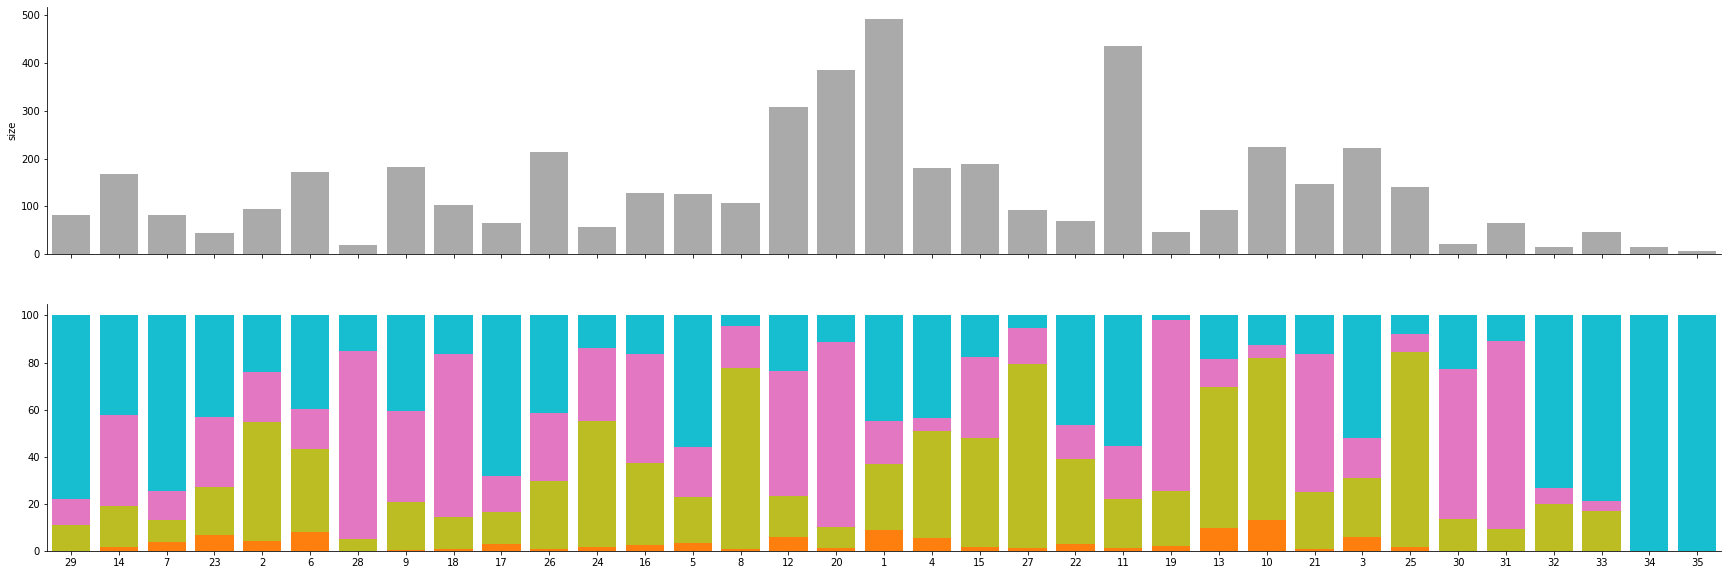

In [23]:
f,ax = plt.subplots(2,1,sharex=True, figsize=(30,10))

sns.barplot(np.arange(len(sizes_composition_df)), sizes_composition_df["size"][coms_plot_idx], ax=ax[0], color="#aaaaaa")


for ax_id in range(2):
    # Hide the right and top spines
    ax[ax_id].spines['right'].set_visible(False)
    ax[ax_id].spines['top'].set_visible(False)
    ax[ax_id].set_xlim([-.5,len(sizes_composition_df)-.5])
    ax[ax_id].set_facecolor('None')

for i,database in enumerate(databases):
    bottoms = database_distributions_df[databases[:i]].sum(axis=1) * 100
    heights = database_distributions_df[database].values * 100
    
    ax[1].bar(np.arange(len(coms_plot_idx)), heights[coms_plot_idx], bottom=bottoms.values[coms_plot_idx],  color=database_colors[database])

    ax[1].set_xticklabels((np.asarray(sizes_composition_df.index)+1).astype(str))